In [1]:
%load_ext autoreload
%matplotlib inline
import sys

import pyTigerGraph
pyTigerGraph.__path__

['/home/tigergraph/conda/lib/python3.9/site-packages/pyTigerGraph']

# Recommender System with EvolveGCN on Pytorch Geometric
Dataset: LastFM (based: [JODIE: Predicting Dynamic Embedding Trajectory in Temporal Interaction Networks](http://snap.stanford.edu/jodie/))
GNN Model: LightGCN [\[2002.02126\] LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/abs/2002.02126)

### Connect to TigerGraph

In [2]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="http://127.0.0.1", # Change the address to your database server's
    graphname="LastFM",  # Specify LastFM dataset
    username="tigergraph",
    password="tigergraph"
)

In [3]:
%%time
# Basic metadata about the graph such as schema.
print(conn.gsql("ls"))

---- Graph LastFM
Vertex Types:
- VERTEX User(PRIMARY_ID vid INT, x LIST<INT>, y INT, train_mask BOOL, val_mask BOOL, test_mask BOOL) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
- VERTEX Item(PRIMARY_ID vid INT, x LIST<INT>, y INT, train_mask BOOL, val_mask BOOL, test_mask BOOL) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
Edge Types:
- DIRECTED EDGE Interact(FROM User, TO Item, train_mask BOOL DEFAULT "False", val_mask BOOL DEFAULT "False", test_mask BOOL DEFAULT "False", time INT DEFAULT "2000")

Graphs:
- Graph LastFM(User:v, Item:v, Interact:e)
Jobs:
- CREATE LOADING JOB load_lastfm FOR GRAPH LastFM {
DEFINE FILENAME item_file = "./lastfm_items.csv";
DEFINE FILENAME edge_file = "./lastfm_edges.csv";
DEFINE FILENAME user_file = "./lastfm_users.csv";
LOAD user_file TO VERTEX User VALUES($"node_id", LIST("0"), "0", "False", "False", "False") USING SEPARATOR=",", HEADER="true", EOL="\n";
LOAD item_file TO VERTEX Item VALUES($"node_id", LIST(

In [4]:
print("Vertex Count:", conn.getVertexCount('*'))
print("Edge Count:", conn.getEdgeCount('*'))

Vertex Count: {'User': 980, 'Item': 1000}
Edge Count: {'Interact': 154993}


(Custimization Point for pyTigerGraph)
 In order to handle bipartite graphs which is comprised of users and items, we explicty specify # of users and items - which is required to compute the similarty score between user embeddings and items embeddings in GNN models.  To create a matrix for users/items embedding, we need to know # of users and items.  To that end. pyTigerGraph should support functions or attributes to extract these numbers for bipartite graphs - by propopsing two functions - tgraph.number_of_source_vertices(), tgraph.number_of_target_vertices(). These proposed methods should be used for general graphs as long as we target recommendation tasks.

In [5]:
num_users, num_items = conn.getVertexCount("User"), conn.getVertexCount("Item")
num_nodes = num_users + num_items

(Not needed for Recommender Systems since this is based on nodes !!) ### Train/validation/test split by nodes

In recommendation tasks, the input dataset must be split by edges instead of nodes. pyTigerGraph supports node masking to split dataset, but edge masking and custom functions, which extract subgraphs with specified set of edges (training / validation / testing edges ), should be also provided.

In [6]:
%%time
# Train : Val : Test = 70 : 15 : 15
splitter = conn.gds.edgeSplitter(train_mask=0.70, val_mask=0.15, test_mask=0.15)
splitter.run()

Splitting edges...
Edge split finished successfully.
CPU times: user 148 ms, sys: 8.03 ms, total: 156 ms
Wall time: 909 ms


(Customization Point to pyTigerGraph!) 
# Graph loader with edge features
Currently the `GraphLoader` of pyTigerGraph only considers node-based labels but for recommender systems, it needs to support edge-based labels (training/validation/testing) to split datasets into training/validation/testing datasets by edge masking and custom functions. To implement this feature, we need to write GSQL to get edge-based labels. 

In [7]:
graph_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=[],
    v_extra_feats=[],
    e_in_feats=["time"],
    e_out_labels=[],
    e_extra_feats=["train_mask", "val_mask", "test_mask"],
    num_batches=1,
    shuffle=False,
    output_format="PyG",
    add_self_loop=False,
    loader_id=None,
    buffer_size=4
)

In [8]:
# Get the whole graph from the loader in PyG format
whole_graph = graph_loader.data
whole_graph

Data(edge_index=[2, 154993], edge_feat=[154993], train_mask=[154993], val_mask=[154993], test_mask=[154993], x=[1980])

(Customization Point to pyTorchGraph) 
## Extract sub-dataset by edges
The following codes are not needed for node classification since PyG supports node-based partioning to trainining/validation/testing. As previously described, edge partioning is needed for link prediction or recommender tasks. To solve this constraint, The `GraphLoader` should provide custom functions to extract subgraphs for training/validation/testing  based on edges.  The following "train_data" or "val_data'. .. indicate subgraphs in PyG. 

In [9]:
train_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=[],
    v_extra_feats=[],
    e_in_feats=["time"],
    e_out_labels=[],
    e_extra_feats=["train_mask"],
    num_batches=1,
    shuffle=False,
    filter_by="train_mask",
    output_format="PyG",
    add_self_loop=False,
    loader_id=None,
    buffer_size=4
)
train_graph = train_loader.data
train_graph

Data(edge_index=[2, 108539], edge_feat=[108539], train_mask=[108539], x=[1971])

In [10]:
val_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=[],
    v_extra_feats=[],
    e_in_feats=["time"],
    e_out_labels=[],
    e_extra_feats=["val_mask"],
    num_batches=1,
    shuffle=False,
    filter_by="val_mask",
    output_format="PyG",
    add_self_loop=False,
    loader_id=None,
    buffer_size=4
)
val_graph = val_loader.data
val_graph

Data(edge_index=[2, 23151], edge_feat=[23151], val_mask=[23151], x=[1932])

In [11]:
test_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=[],
    v_extra_feats=[],
    e_in_feats=["time"],
    e_out_labels=[],
    e_extra_feats=["test_mask"],
    num_batches=1,
    shuffle=False,
    filter_by="test_mask",
    output_format="PyG",
    add_self_loop=False,
    loader_id=None,
    buffer_size=4
)
test_graph = test_loader.data
test_graph

Data(edge_index=[2, 23303], edge_feat=[23303], test_mask=[23303], x=[1932])

## Create and set bipartite edges to train/val/test subgraphs

For each subgraph dataset (training, validation and testing), construct undirected bipartite edges for message passing in the EvolveGCN model from the directed edges as the ground-truth labels of the link prediction.

In [12]:
from torch_geometric.utils import to_undirected

train_edge_index_d = train_graph.edge_index
train_edge_index_u = to_undirected(train_edge_index_d)
train_graph.edge_label_index = train_edge_index_d
train_graph.edge_index = train_edge_index_u

val_edge_index_d = val_graph.edge_index
val_edge_index_u = to_undirected(val_edge_index_d)
val_graph.edge_label_index = val_edge_index_d
val_graph.edge_index = val_edge_index_u

test_edge_index_d = test_graph.edge_index
test_edge_index_u = to_undirected(test_edge_index_d)
test_graph.edge_label_index = test_edge_index_d
test_graph.edge_index = test_edge_index_u

In [13]:
train_graph, val_graph, test_graph

(Data(edge_index=[2, 217078], edge_feat=[108539], train_mask=[108539], x=[1971], edge_label_index=[2, 108539]),
 Data(edge_index=[2, 46302], edge_feat=[23151], val_mask=[23151], x=[1932], edge_label_index=[2, 23151]),
 Data(edge_index=[2, 46606], edge_feat=[23303], test_mask=[23303], x=[1932], edge_label_index=[2, 23303]))

# Construct LightGCN model and optimizer

We build an EvolveGCN model, and use the Adam optimizer with a learning rate of 0.001.

In [14]:
%autoreload
import numpy as np
import torch
from torch.optim import Optimizer
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

sys.path.append("..")
from recsys.model.egcn import EGCN
from recsys.config import config
from recsys.utils.sample_negative import sample_negative_edges
from recsys.data.lastfm import LastFMDataset

print("EvolveGCN training configuration:", config)

EvolveGCN training configuration: Config(epochs=10, k=10, num_layers=2, batch_size=1000, embedding_dim=64, lr=0.001, model_name='egcn', save_emb_dir=None)


## Construct model and optimizer

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = config.embedding_dim

gnn = EGCN(
    embedding_dim=input_dim,
    num_nodes=num_nodes,
    num_users=num_users,
    num_layers=config.num_layers,
).to(device)

opt = torch.optim.Adam(gnn.parameters(), lr=config.lr)  # using Adam optimizer

## Training and Testing

In [16]:
def train(
    model,  # GNN (EvolveGCN) model
    data_mp: Data,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of supervision/evaluation edges
    opt: Optimizer,  # Optimizer
    num_customers: int,  # Number of user nodes
    num_nodes: int,  # Number of total nodes (users + items)
    device: torch.device,  # Device (CPU or GPU)
):
    total_loss = 0
    total_examples = 0
    model.train()
    i = 0
    for batch in loader:  # positive (existing) edges
        i += 1
        del batch.batch
        del batch.ptr  # delete unwanted attributes

        opt.zero_grad()
        # Generate negative (non-existing) edges
        negs = sample_negative_edges(batch, num_customers, num_nodes, device)
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)  # Train and compute loss
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

In [17]:
def test(
    model,  # GNN (EvolveGCN) model
    data_mp: Data,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of evaluation edges
    k: int,  # Top-k
    device: torch.device,  # Device (CPU or GPU)
):
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        data_mp = data_mp.to(device)  # Save multi-scale embeddings if save_dir is not None

        # Run evaluation
        for batch in loader:  # Batches of positive (existing) edges
            del batch.batch; del batch.ptr  # delete unwanted attributes
            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)  # Evaluate model performance
            for customer_idx in recalls:
                assert customer_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

## Prepare existing edges for ground-truth data by representing them as edge list
For each subgraph dataset (training, validation and testing), construct a `DataLoader` to load ground-truth positive (existing) edges for training.

In [18]:
train_existing_edges = LastFMDataset("tmp", edge_index=train_graph.edge_label_index)
val_existing_edges = LastFMDataset("tmp", edge_index=val_graph.edge_label_index)
test_existing_edges = LastFMDataset("tmp", edge_index=test_graph.edge_label_index)

train_label_loader = DataLoader(train_existing_edges, batch_size=config.batch_size, shuffle=True)
val_label_loader = DataLoader(val_existing_edges, batch_size=config.batch_size, shuffle=False)
test_label_loader = DataLoader(test_existing_edges, batch_size=config.batch_size, shuffle=False)

### Train the model

In [19]:
%%time

from time import time

input_dim = config.embedding_dim

all_train_losses = list()  # list of (epoch, training loss)
all_val_recalls = list()  # list of (epoch, validation recall@k)
all_train_recalls_lgcn = list()  # list of training recalls in LightGCN

st = time()
for epoch in range(config.epochs):
    train_loss = train(gnn, train_graph, train_label_loader, opt, num_users, num_nodes, device)
    all_train_losses.append((epoch, train_loss))

    val_recall = test(gnn, val_graph, val_label_loader, config.k, device)
    all_val_recalls.append((epoch, val_recall))
    all_train_recalls_lgcn.append(val_recall)
    tm = time() - st
    print(f"Epoch {epoch}: train loss={train_loss:.6f}, val_recall={val_recall:.6f}, time={tm:.2f}[s]")

/home/tigergraph/conda/lib/python3.9/site-packages/torch_geometric/data/storage.py:261: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=0.693157, val_recall=0.001286, time=0.79[s]
Epoch 1: train loss=0.693143, val_recall=0.001215, time=1.53[s]
Epoch 2: train loss=0.693132, val_recall=0.002284, time=2.25[s]
Epoch 3: train loss=0.693107, val_recall=0.001685, time=3.01[s]
Epoch 4: train loss=0.693060, val_recall=0.001368, time=3.74[s]
Epoch 5: train loss=0.692991, val_recall=0.001987, time=4.43[s]
Epoch 6: train loss=0.692894, val_recall=0.001391, time=5.14[s]
Epoch 7: train loss=0.692761, val_recall=0.002707, time=5.86[s]
Epoch 8: train loss=0.692581, val_recall=0.002348, time=6.57[s]
Epoch 9: train loss=0.692343, val_recall=0.002348, time=7.26[s]
CPU times: user 37.2 s, sys: 1min 4s, total: 1min 41s
Wall time: 7.26 s


### Test the model

In [20]:
# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key=lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall = test(gnn, test_graph, test_label_loader, config.k, device)
print(f"Test set recall@k: {test_recall}")

Best validation recall@k: 0.0027065527065527066 at epoch 7
Test set recall@k: 0.0006060606060606061


### Visualize testing results

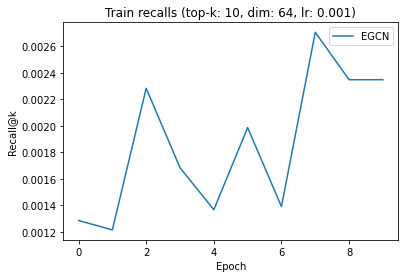

In [21]:
import matplotlib.pyplot as plt

all_epochs = list(range(len(all_train_recalls_lgcn)))
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(all_epochs, all_train_recalls_lgcn, label="EGCN")
plt.xlabel("Epoch")
plt.ylabel("Recall@k")
plt.title(f"Train recalls (top-k: {config.k}, dim: {input_dim}, lr: {config.lr})")
plt.legend()
plt.show()